## dice detection

/home/chupakabra/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



=== TEST IMAGE 1 ===


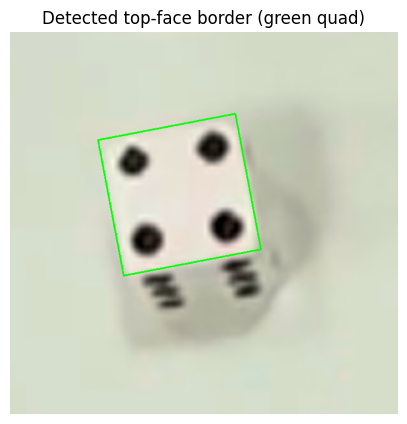

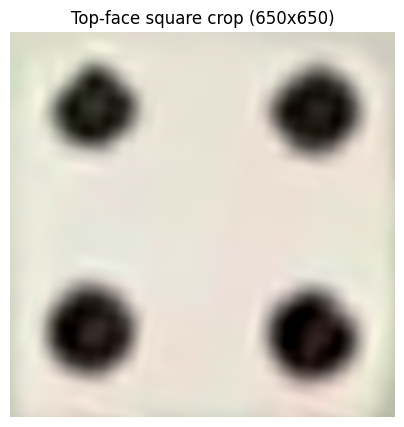

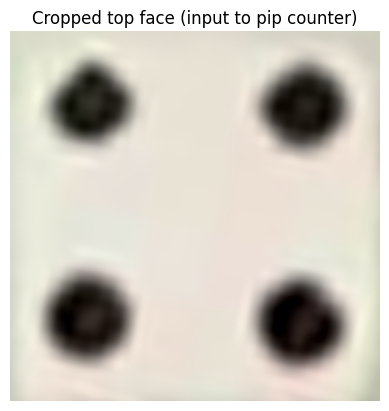

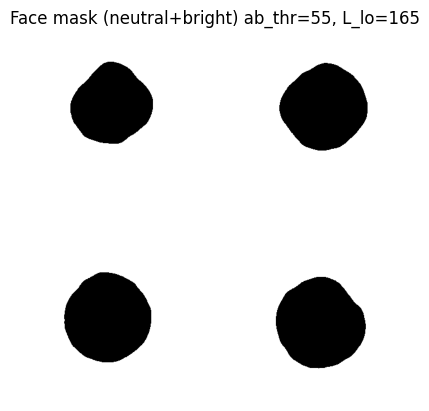

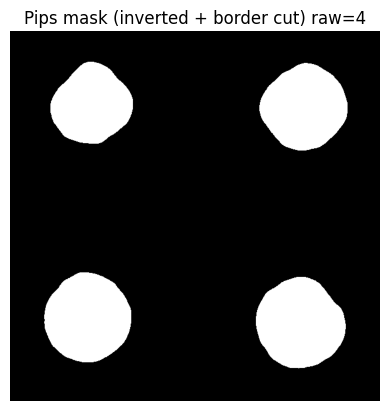

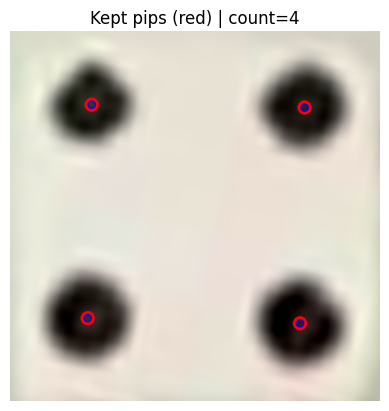

RAW COUNT: 4
FINAL COUNT: 4

=== PIPELINE RESULT ===
TOP-FACE PIPS: 4
{'pip_count': 4, 'raw_count': 4, 'centers': [(142.7704777027921, 129.03506682545984), (516.5948723805174, 133.64546337006794), (135.7477695367086, 503.6050736321617), (508.97740201450864, 513.3894368769897)], 'areas': [15114, 17513, 18606, 19161]}

=== TEST IMAGE 2 ===


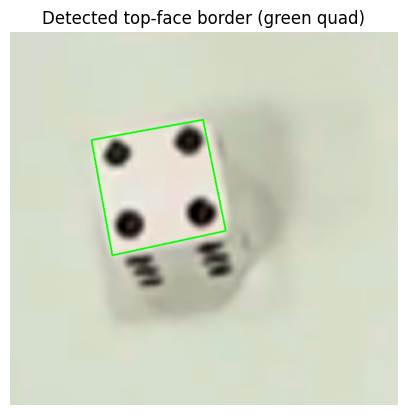

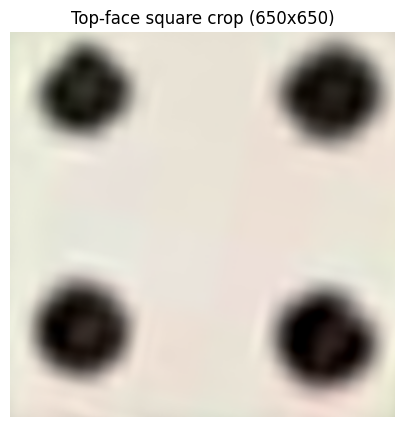

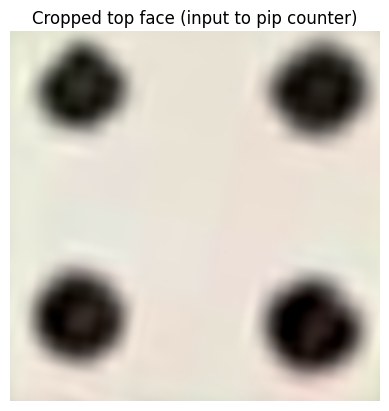

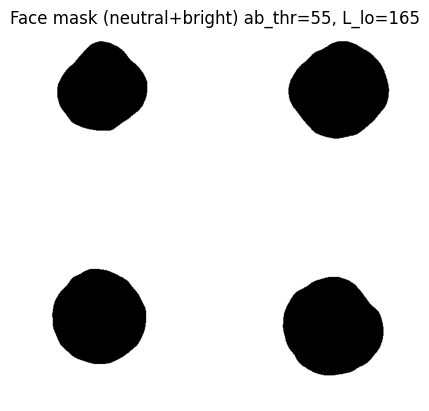

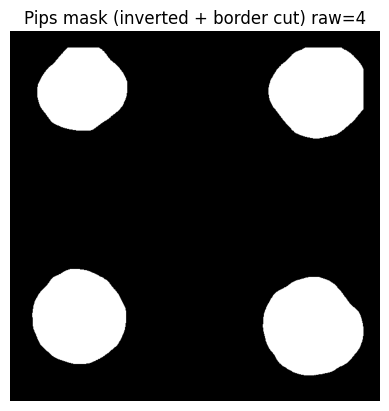

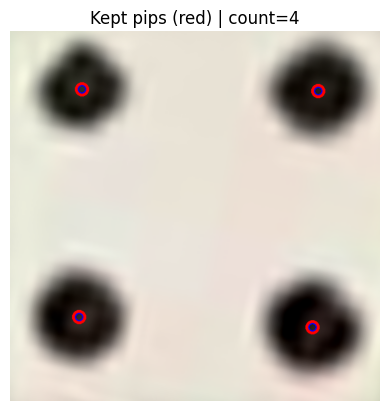

RAW COUNT: 4
FINAL COUNT: 4

=== PIPELINE RESULT ===
TOP-FACE PIPS: 4
{'pip_count': 4, 'raw_count': 4, 'centers': [(126.17817726703835, 101.84668335419273), (541.4740232262918, 105.48775212750952), (120.63012793277629, 502.14945947221827), (530.6878204299685, 519.7502046443497)], 'areas': [17578, 21269, 21183, 23211]}

=== TEST IMAGE 3 ===


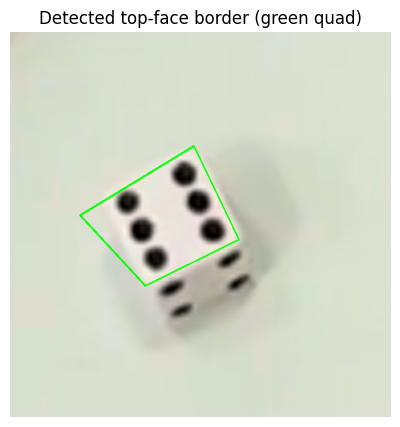

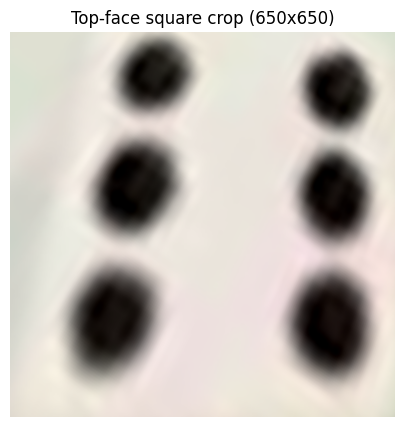

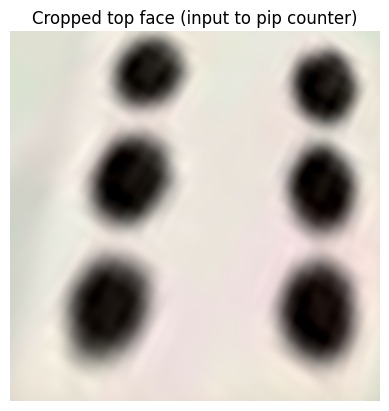

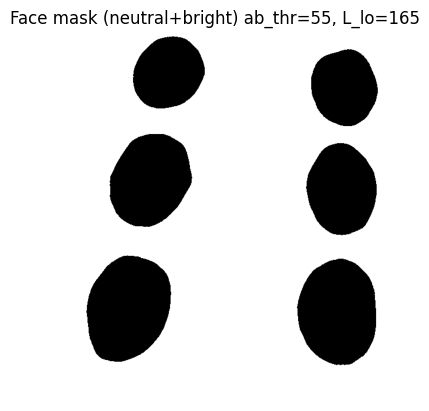

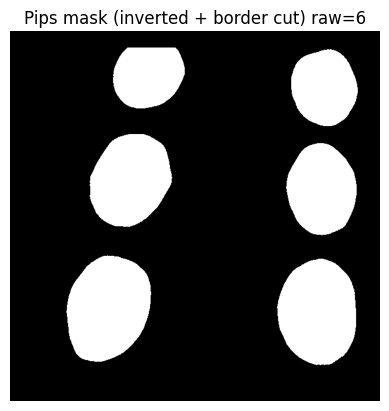

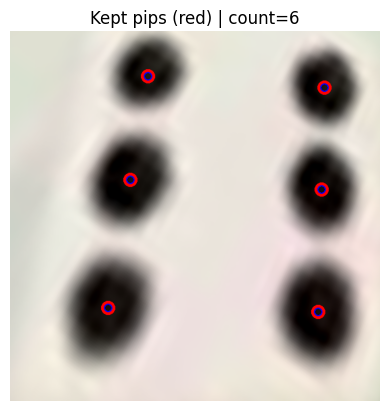

RAW COUNT: 6
FINAL COUNT: 6

=== PIPELINE RESULT ===
TOP-FACE PIPS: 6
{'pip_count': 6, 'raw_count': 6, 'centers': [(242.0327191011236, 78.54319101123596), (551.6531546256947, 98.82535142203335), (210.70523507835946, 261.17277981549404), (547.1334682156377, 278.0084192664143), (171.66938300349244, 486.4870779976717), (540.7442337763878, 493.4750293197811)], 'areas': [11125, 12236, 17994, 15322, 21475, 20464]}

=== TEST IMAGE 4 ===


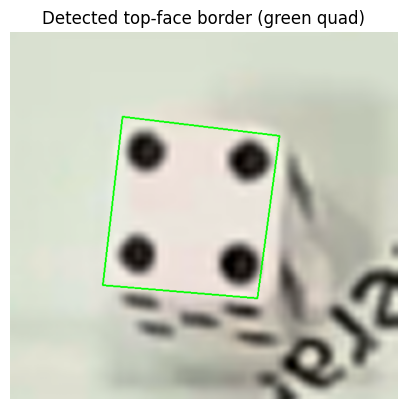

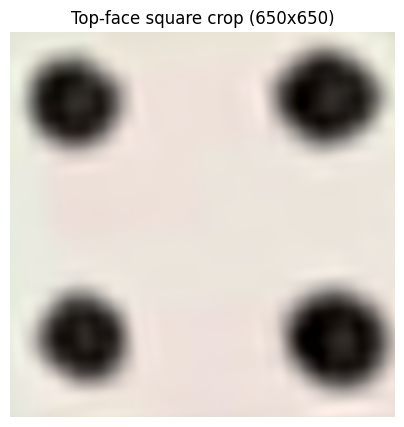

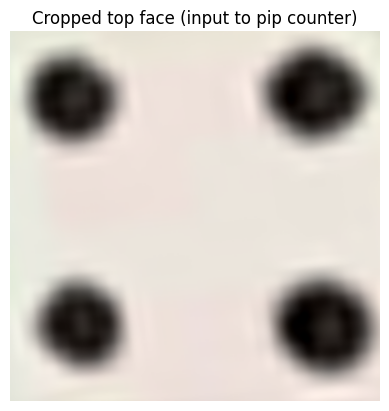

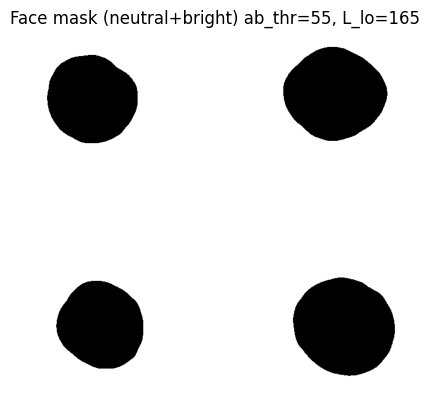

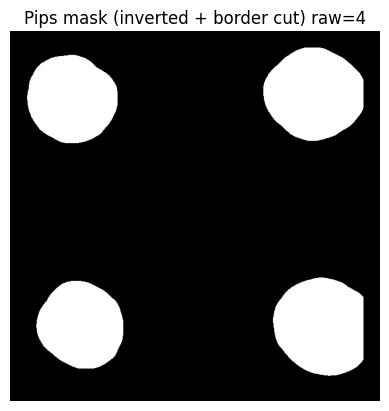

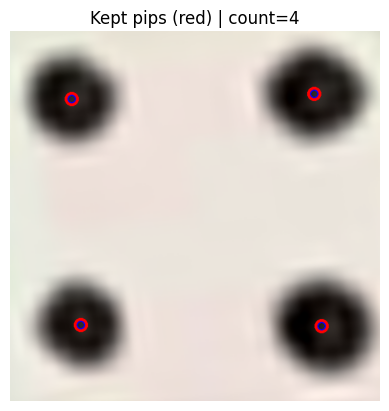

RAW COUNT: 4
FINAL COUNT: 4

=== PIPELINE RESULT ===
TOP-FACE PIPS: 4
{'pip_count': 4, 'raw_count': 4, 'centers': [(534.0441309051569, 110.14862062747926), (107.82356923397386, 118.99437587876895), (546.6218950006713, 518.4451058497068), (124.19590643274854, 516.392033542977)], 'areas': [22184, 19203, 22343, 18126]}

=== TEST IMAGE 5 ===


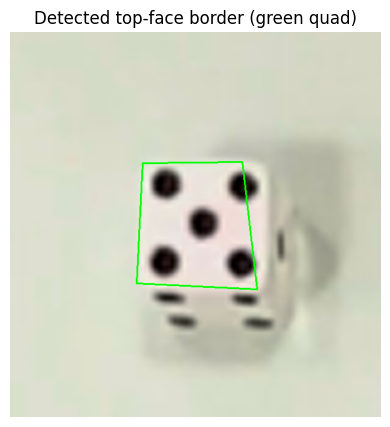

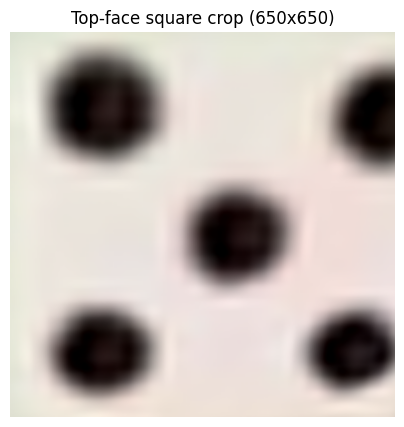

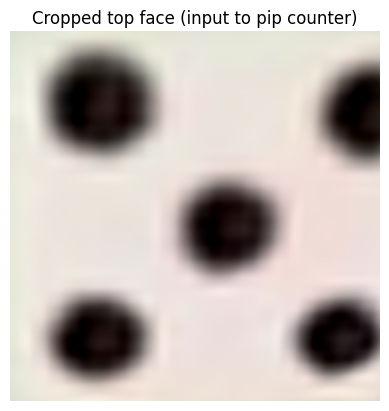

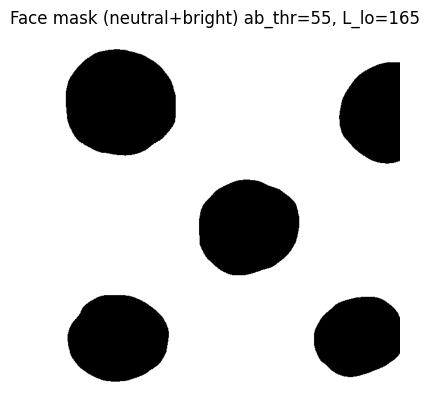

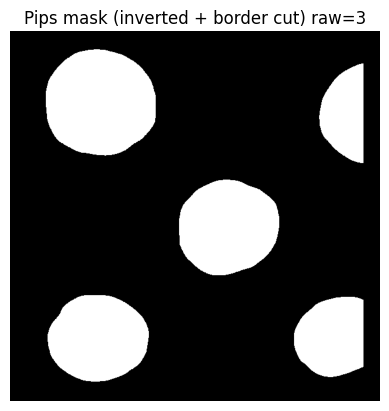

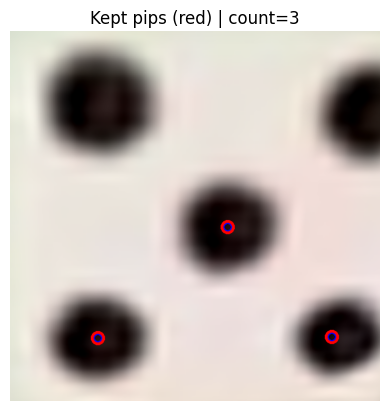

RAW COUNT: 3
FINAL COUNT: 3

=== PIPELINE RESULT ===
TOP-FACE PIPS: 3
{'pip_count': 3, 'raw_count': 3, 'centers': [(382.43872958724444, 344.27315588701725), (154.22486384087142, 539.3246507222353), (565.4609605392501, 536.9713523381547)], 'areas': [23331, 21115, 14242]}

=== TEST IMAGE 6 ===


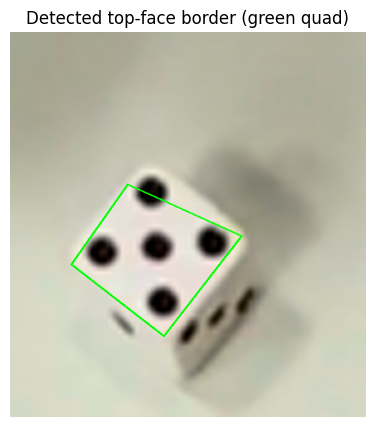

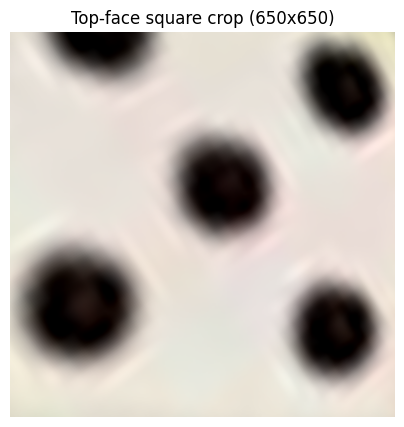

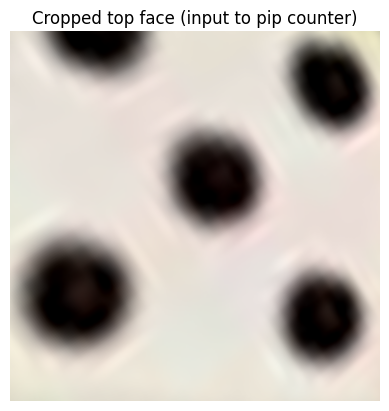

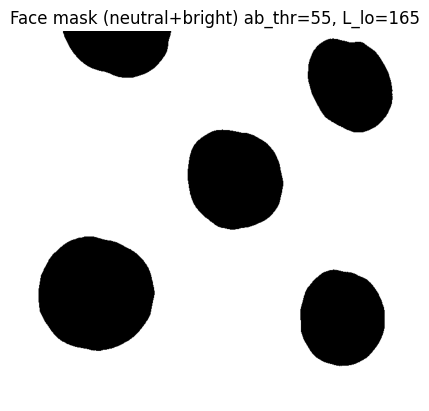

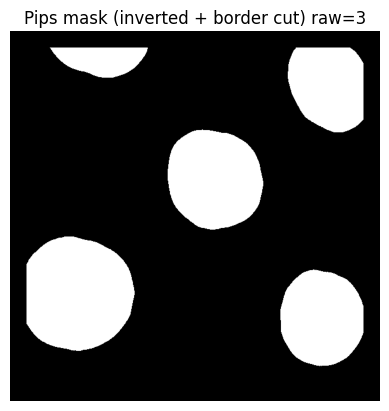

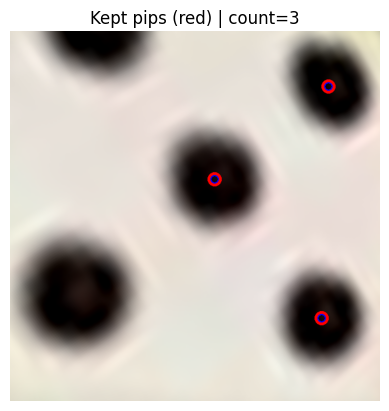

RAW COUNT: 3
FINAL COUNT: 3

=== PIPELINE RESULT ===
TOP-FACE PIPS: 3
{'pip_count': 3, 'raw_count': 3, 'centers': [(558.7991058122205, 96.85663189269746), (358.7963073511854, 259.82393825686506), (547.2541054014451, 503.84791066646454)], 'areas': [16775, 23452, 19791]}

=== TEST IMAGE 7 ===


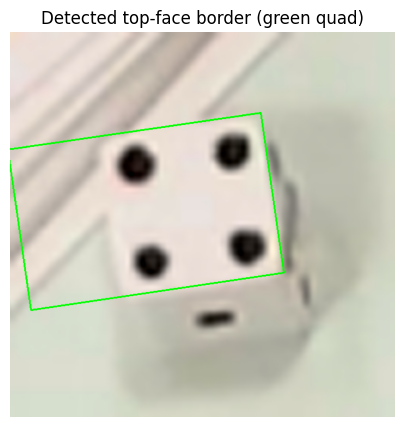

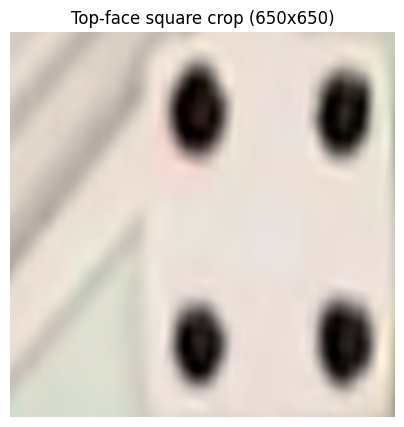

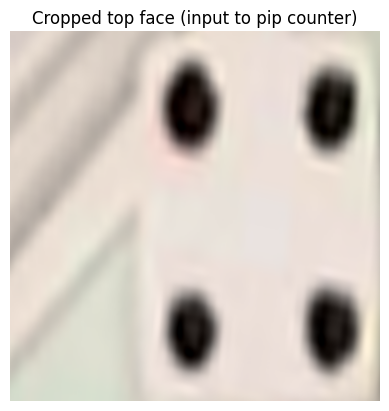

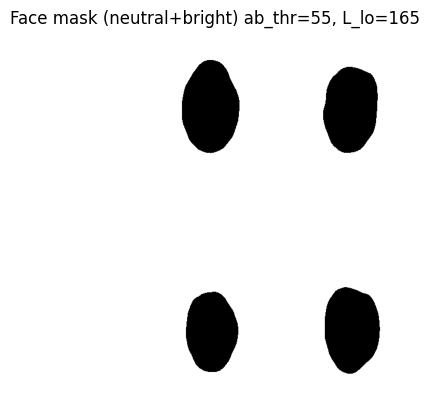

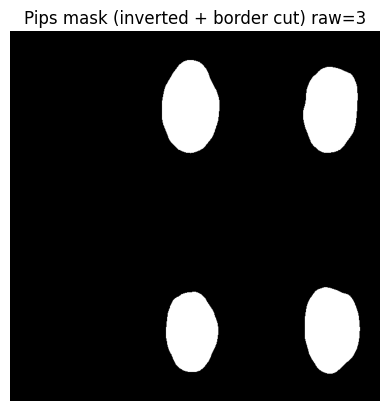

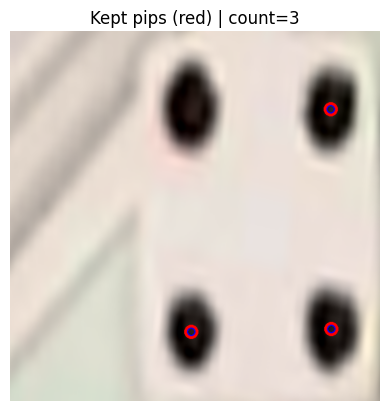

RAW COUNT: 3
FINAL COUNT: 3

=== PIPELINE RESULT ===
TOP-FACE PIPS: 3
{'pip_count': 3, 'raw_count': 3, 'centers': [(563.172112724758, 136.82123098201936), (564.408988957902, 523.4155452035886), (318.2435541451805, 527.6680880602935)], 'areas': [11568, 11592, 10084]}

=== TEST IMAGE 8 ===


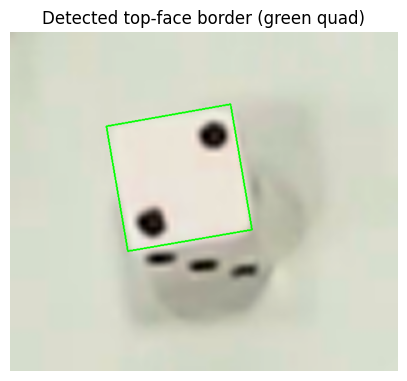

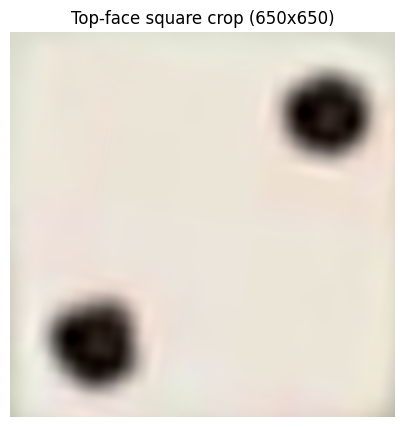

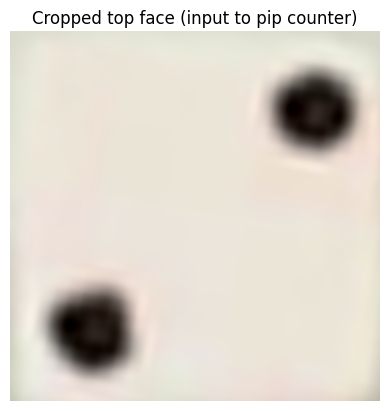

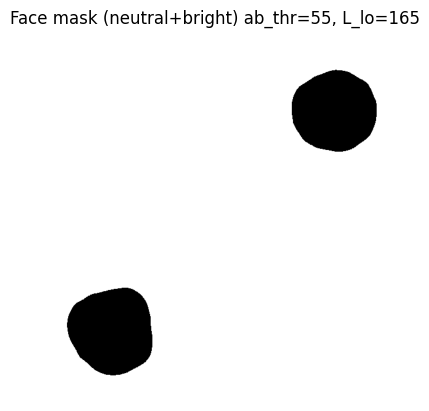

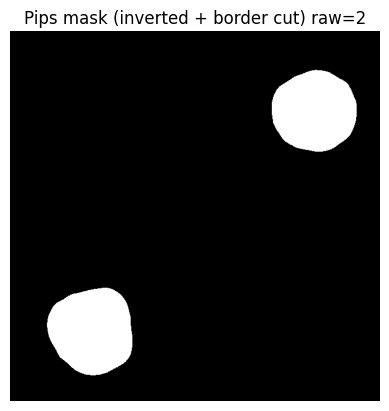

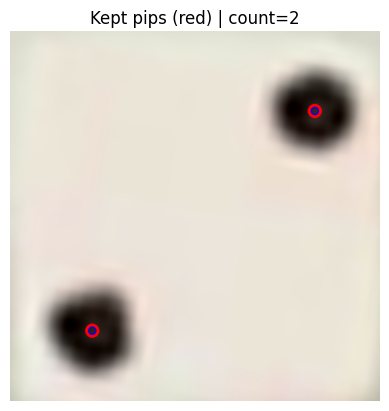

RAW COUNT: 2
FINAL COUNT: 2

=== PIPELINE RESULT ===
TOP-FACE PIPS: 2
{'pip_count': 2, 'raw_count': 2, 'centers': [(534.570970042796, 140.31211364717072), (143.5381892594436, 526.2001548586915)], 'areas': [16824, 18081]}

=== TEST IMAGE 9 ===


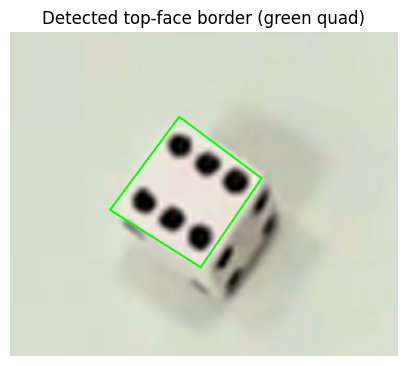

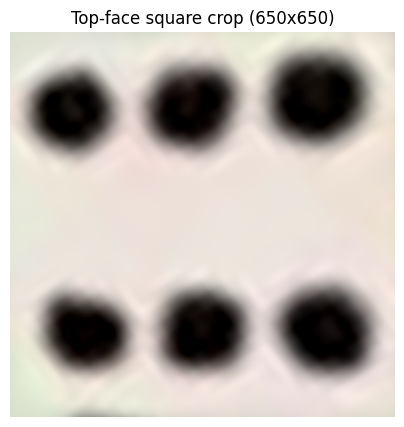

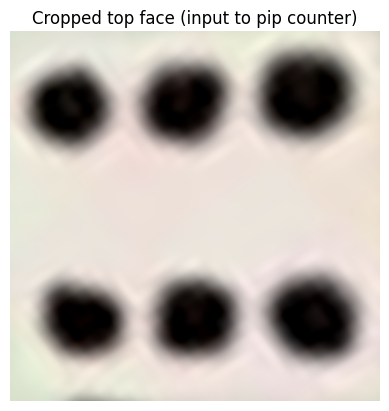

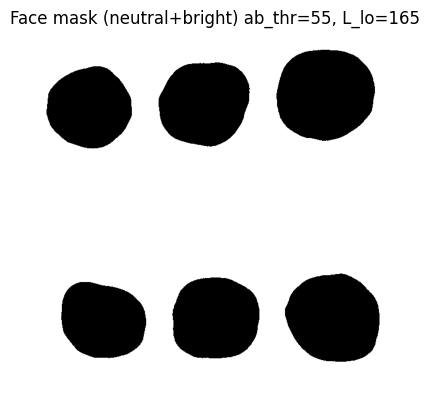

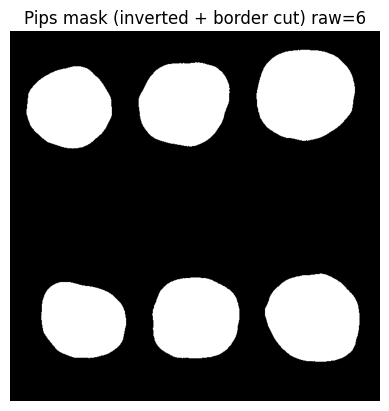

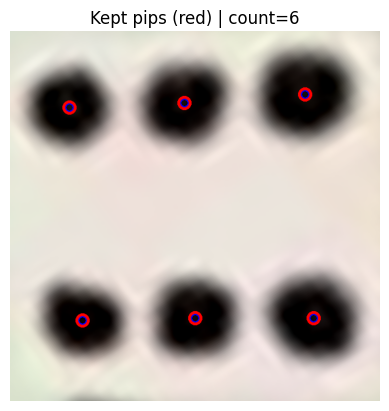

RAW COUNT: 6
FINAL COUNT: 6

=== PIPELINE RESULT ===
TOP-FACE PIPS: 6
{'pip_count': 6, 'raw_count': 6, 'centers': [(517.87557437607, 110.69947743039914), (305.88694360443526, 126.38490105575893), (104.00553916551267, 134.1095189355169), (533.350036809816, 503.87489570552145), (325.17133543289685, 504.47952925576), (127.08500405970895, 507.5761663856099)], 'areas': [22198, 18849, 16609, 20375, 18099, 16011]}


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_die_top_face_square_with_border(
    die_input,
    out_size=650,
    upscale_long_side=650,
    ab_thr=38,
    L_min=170,
    L_quantile=92,     
    open_k=7,
    close_k=21,
    close_iter=2,
    pad_frac=0.03,    
    debug=True
):
    def _to_bgr(x):
        if isinstance(x, str):
            img = cv2.imread(x, cv2.IMREAD_COLOR)
            if img is None:
                raise ValueError(f"Could not read image: {x}")
            return img
        arr = np.asarray(x)
        if arr.ndim != 3 or arr.shape[2] not in (3, 4):
            raise ValueError("die_input must be a path or an HxWx3(/4) image array.")
        if arr.shape[2] == 4:
            arr = arr[:, :, :3]
        return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

    def _resize_long(bgr, target):
        h, w = bgr.shape[:2]
        s = float(target) / max(h, w)
        if abs(s - 1.0) < 1e-6:
            return bgr.copy(), 1.0
        out = cv2.resize(
            bgr,
            (max(1, int(w * s)), max(1, int(h * s))),
            interpolation=cv2.INTER_CUBIC if s > 1 else cv2.INTER_AREA
        )
        return out, s

    def _order_quad(pts4):
        pts = np.array(pts4, dtype=np.float32)
        s = pts.sum(axis=1)
        d = np.diff(pts, axis=1).reshape(-1)
        tl = pts[np.argmin(s)]
        br = pts[np.argmax(s)]
        tr = pts[np.argmin(d)]
        bl = pts[np.argmax(d)]
        return np.stack([tl, tr, br, bl], axis=0)

    def _show_bgr(bgr, title):
        plt.figure(figsize=(5,5))
        plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()

    bgr0 = _to_bgr(die_input)
    bgr, _ = _resize_long(bgr0, upscale_long_side)

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, bb = cv2.split(lab)

    neutral = ((np.abs(a.astype(np.int16) - 128) <= int(ab_thr)) &
               (np.abs(bb.astype(np.int16) - 128) <= int(ab_thr)))

    if np.any(neutral):
        thr = max(int(L_min), int(np.percentile(L[neutral], int(L_quantile))))
    else:
        thr = int(L_min)

    bright = (L >= thr)
    mask = (neutral & bright).astype(np.uint8) * 255

    ok = int(open_k) | 1
    ck = int(close_k) | 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,
                            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ok, ok)),
                            iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ck, ck)),
                            iterations=int(close_iter))

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        H, W = bgr.shape[:2]
        side = min(H, W)
        y0 = (H - side) // 2
        x0 = (W - side) // 2
        face_sq = cv2.resize(bgr[y0:y0+side, x0:x0+side], (out_size, out_size), interpolation=cv2.INTER_AREA)
        if debug:
            _show_bgr(bgr, "Top-face detect FAILED (no contour) -> fallback center crop")
            _show_bgr(face_sq, "Top-face square (fallback)")
        return face_sq

    cnt = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 80:
        face_sq = cv2.resize(bgr, (out_size, out_size), interpolation=cv2.INTER_AREA)
        if debug:
            _show_bgr(bgr, "Top-face detect FAILED (tiny contour) -> fallback resize")
            _show_bgr(face_sq, "Top-face square (fallback)")
        return face_sq

    peri = cv2.arcLength(cnt, True)
    quad = None
    for eps_frac in (0.02, 0.03, 0.04, 0.05, 0.06):
        approx = cv2.approxPolyDP(cnt, eps_frac * peri, True)
        if len(approx) == 4:
            quad = approx.reshape(4, 2).astype(np.float32)
            break
    if quad is None:
        rect = cv2.minAreaRect(cnt)
        quad = cv2.boxPoints(rect).astype(np.float32)

    src = _order_quad(quad)

    c = src.mean(axis=0, keepdims=True)
    src = (src - c) * (1.0 + float(pad_frac)) + c

    dst = np.array([[0,0],[out_size-1,0],[out_size-1,out_size-1],[0,out_size-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    face_sq = cv2.warpPerspective(bgr, M, (out_size, out_size),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    vis = bgr.copy()
    cv2.polylines(vis, [src.astype(np.int32).reshape(-1,1,2)], True, (0,255,0), 2)

    if debug:
        _show_bgr(vis, "Detected top-face border (green quad)")
        _show_bgr(face_sq, f"Top-face square crop ({out_size}x{out_size})")

    return face_sq


def count_pips_on_cropped_top_face(
    face_bgr,
    debug=True,
    ab_thr=55,
    L_lo=165,
    open_k=3,
    close_k=9,
    close_iter=1,
    border_frac=0.045,
    min_area_frac=0.0012,
    max_area_frac=0.06,
    max_aspect=1.6,
    keep_k=6,
    neighbor_dist_frac=0.20,
    grid_snap_frac=0.10
):
    def _show(im, title, gray=False):
        plt.figure(figsize=(4.8, 4.8))
        if gray:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()

    def _quantize_1d(vals, tol):
        groups = []
        for v in sorted(vals):
            placed = False
            for g in groups:
                if abs(v - g[0]) <= tol:
                    g.append(v)
                    g[0] = float(np.mean(g[1:]))
                    placed = True
                    break
            if not placed:
                groups.append([float(v), float(v)])
        return [g[0] for g in groups]

    bgr = face_bgr.copy()
    h, w = bgr.shape[:2]

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, bb = cv2.split(lab)

    neutral = ((np.abs(a.astype(np.int16) - 128) <= int(ab_thr)) &
               (np.abs(bb.astype(np.int16) - 128) <= int(ab_thr))).astype(np.uint8) * 255
    bright_enough = (L >= int(L_lo)).astype(np.uint8) * 255

    face_mask = cv2.bitwise_and(neutral, bright_enough)

    ok = int(open_k) | 1
    ck = int(close_k) | 1
    face_mask = cv2.morphologyEx(face_mask, cv2.MORPH_OPEN,
                                 cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ok, ok)),
                                 iterations=1)
    face_mask = cv2.morphologyEx(face_mask, cv2.MORPH_CLOSE,
                                 cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ck, ck)),
                                 iterations=int(close_iter))

    pips = cv2.bitwise_not(face_mask)

    bx = int(border_frac * w)
    by = int(border_frac * h)
    pips[:by, :] = 0
    pips[-by:, :] = 0
    pips[:, :bx] = 0
    pips[:, -bx:] = 0

    num, labels, stats, centroids = cv2.connectedComponentsWithStats(pips, connectivity=8)

    area_img = h * w
    min_area = int(min_area_frac * area_img)
    max_area = int(max_area_frac * area_img)

    centers = []
    areas = []

    for i in range(1, num):
        x, y, ww, hh, aarea = stats[i]
        if aarea < min_area or aarea > max_area:
            continue
        asp = max(ww / max(1, hh), hh / max(1, ww))
        if asp > max_aspect:
            continue
        cx, cy = centroids[i]
        centers.append((float(cx), float(cy)))
        areas.append(int(aarea))

    raw_count = len(centers)

    if raw_count <= 6:
        kept = list(range(raw_count))
    else:
        P = np.array(centers, dtype=np.float32)
        D = np.sqrt(((P[:, None, :] - P[None, :, :]) ** 2).sum(axis=2))

        dthr = neighbor_dist_frac * float(min(h, w))
        neigh = (D <= dthr).astype(np.int32)
        np.fill_diagonal(neigh, 0)
        deg = neigh.sum(axis=1)

        seed = int(np.argmax(deg))
        cand = np.where(D[seed] <= dthr)[0].tolist() + [seed]
        cand = sorted(set(cand))

        if len(cand) > keep_k:
            sub = cand.copy()
            kept = [seed]
            sub.remove(seed)
            while len(kept) < keep_k and sub:
                best_j = None
                best_score = -1e18
                for j in sub:
                    score = -float(np.mean([D[j, k] for k in kept]))
                    if score > best_score:
                        best_score = score
                        best_j = j
                kept.append(best_j)
                sub.remove(best_j)
        else:
            kept = cand

        kept_pts = P[kept]
        x_tol = grid_snap_frac * w
        y_tol = grid_snap_frac * h
        xs = _quantize_1d(kept_pts[:, 0].tolist(), x_tol)
        ys = _quantize_1d(kept_pts[:, 1].tolist(), y_tol)

        if len(xs) <= 3 and len(ys) > 3:
            ys_sorted = sorted(ys)
            low = ys_sorted[-1]
            new_kept = [k for k in kept if abs(P[k, 1] - low) > y_tol]
            if 1 <= len(new_kept) <= 6:
                kept = new_kept

    pip_count = len(kept)

    if debug:
        _show(bgr, "Cropped top face (input to pip counter)")
        _show(face_mask, f"Face mask (neutral+bright) ab_thr={ab_thr}, L_lo={L_lo}", gray=True)
        _show(pips, f"Pips mask (inverted + border cut) raw={raw_count}", gray=True)

        overlay = bgr.copy()
        for (cx, cy) in centers:
            cv2.circle(overlay, (int(round(cx)), int(round(cy))), 7, (255, 0, 0), 2)
        for k in kept:
            cx, cy = centers[k]
            cv2.circle(overlay, (int(round(cx)), int(round(cy))), 10, (0, 0, 255), 3)
        _show(overlay, f"Kept pips (red) | count={pip_count}")

        print("RAW COUNT:", raw_count)
        print("FINAL COUNT:", pip_count)

    kept_centers = [centers[i] for i in kept] if raw_count else []
    kept_areas = [areas[i] for i in kept] if raw_count else []

    return {
        "pip_count": int(pip_count),
        "raw_count": int(raw_count),
        "centers": kept_centers,
        "areas": kept_areas,
    }


def read_top_face_pips(die_input, debug=False):
    face = crop_die_top_face_square_with_border(
        die_input,
        out_size=650,
        upscale_long_side=650,
        ab_thr=35,
        L_min=175,
        L_quantile=94,
        open_k=7,
        close_k=15,
        close_iter=1,
        pad_frac=0.03,
        debug=debug
    )

    res = count_pips_on_cropped_top_face(
        face,
        debug=debug,
        ab_thr=55,
        L_lo=165,
        open_k=3,
        close_k=9,
        close_iter=1,
        border_frac=0.045,
        min_area_frac=0.0012,
        max_area_frac=0.06,
        max_aspect=1.6,
        keep_k=6,
        neighbor_dist_frac=0.20,
        grid_snap_frac=0.10
    )

    if debug:
        print("\n=== PIPELINE RESULT ===")
        print("TOP-FACE PIPS:", res["pip_count"])

    return res


for i in range(1, 10):
    print(f"\n=== TEST IMAGE {i} ===")
    res = read_top_face_pips(f"data/dice/image_{i}.png", debug=True)
    print(res)
